<a href="https://colab.research.google.com/github/EzerzerDavid/Assignment1/blob/main/MLAssignmentDavidEzerzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


https://github.com/EzerzerDavid/Assignment1.git



In [10]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.7 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Dropping irrelevant columns such as passenger name, ticket number, cabin, and home destination as they do not contribute to predictive power and may introduce noise.

Performing initial exploratory data analysis (EDA) to understand dataset structure, feature distributions, and missing values.


,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,1,0,female,2.0000,1,2,151.5500,S
3,1,0,male,30.0000,1,2,151.5500,S
4,1,0,female,25.0000,1,2,151.5500,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   survived  1309 non-null   int64  
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   fare      1308 non-null   float64
 7   embarked  1307 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 81.9+ KB


None


Visualizing missing values to identify patterns that may inform our imputation strategy. This helps understand where data is missing and whether it follows any trends.


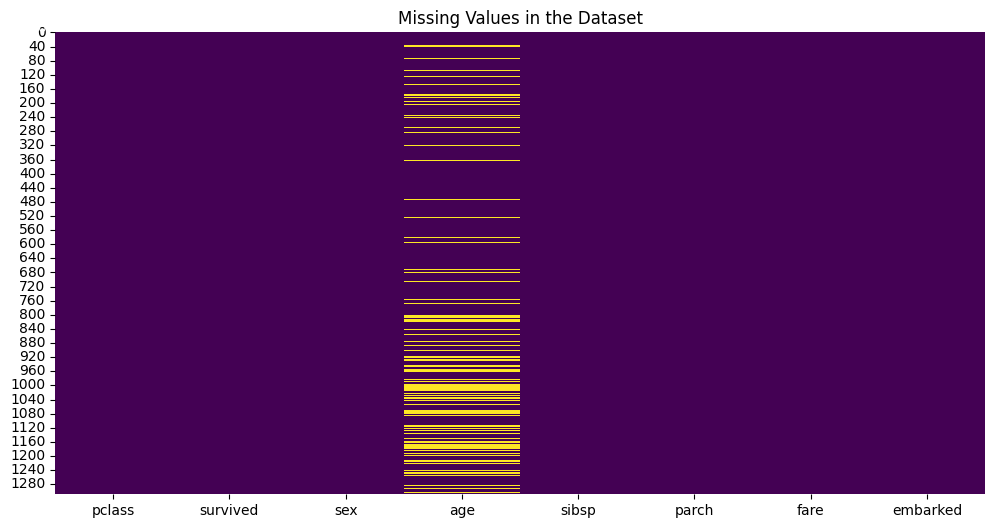


We use median imputation for 'age' because the median is less sensitive to extreme outliers compared to the mean. Similarly, we use median for 'fare' due to potential skewness in the fare distribution. Mode imputation is applied to 'embarked' as it is categorical, ensuring consistency with the most frequently observed value.

Applying Target Encoding to 'embarked' to preserve ordinal relationships while preventing feature explosion. OneHotEncoding is used for 'sex' since it is binary, ensuring no loss of information.

Standardization (StandardScaler) is applied to 'age' and 'fare' to normalize features by centering them around zero with unit variance, making them suitable for models assuming Gaussian distribution. MinMaxScaler is used as an alternative to scale values between 0 and 1, useful for non-parametric models.

A stratified split is performed to maintain class distribution across training, validation, and test sets, ensuring balanced representation in all subsets.

Class weigh

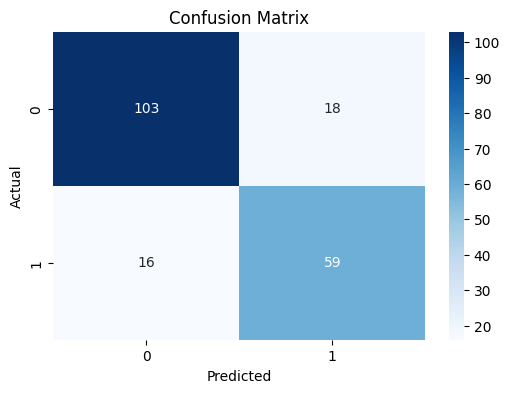


The normalized Confusion Matrix provides better interpretability by converting raw counts into relative proportions.


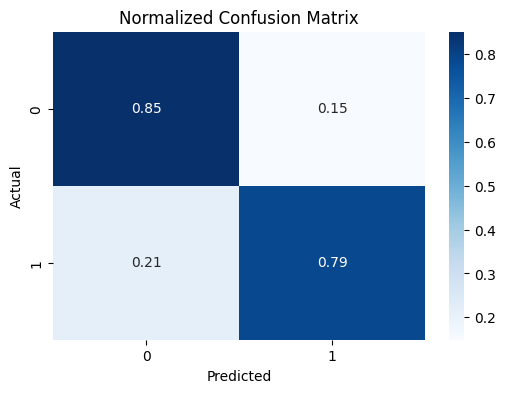


The ROC Curve evaluates classifier performance at different probability thresholds, with AUC summarizing the model’s discrimination capability. A higher AUC indicates better separability between positive and negative classes.


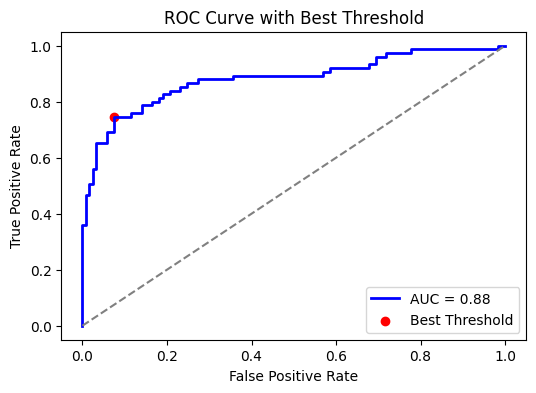


Performing cross-validation ensures the model generalizes well, providing an estimate of performance stability.

Mean Cross-Validation Accuracy: 0.7587


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE, ADASYN
from category_encoders import TargetEncoder
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define file path in Google Drive
file_path = "/content/drive/My Drive/titanic3.xls"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"Dataset not found: {file_path}. Please ensure the file is uploaded to Google Drive.")

df = pd.read_excel(file_path)

# Drop non-numeric and non-relevant columns
print("\nDropping irrelevant columns such as passenger name, ticket number, cabin, and home destination as they do not contribute to predictive power and may introduce noise.")
df.drop(columns=['name', 'ticket', 'cabin', 'boat', 'body', 'home.dest'], inplace=True, errors='ignore')

# Display basic information
print("\nPerforming initial exploratory data analysis (EDA) to understand dataset structure, feature distributions, and missing values.")
display(df.head())
display(df.info())

# Missing Values Visualization
print("\nVisualizing missing values to identify patterns that may inform our imputation strategy. This helps understand where data is missing and whether it follows any trends.")
def visualize_missing_values(df):
    plt.figure(figsize=(12,6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title("Missing Values in the Dataset")

    # Add missing percentage labels
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    for i, v in enumerate(missing_percentage):
        plt.text(i, -1, f"{v:.1f}%", ha='center', fontsize=10, color='white')

    plt.show()

visualize_missing_values(df)

# Handling Missing Values
print("\nWe use median imputation for 'age' because the median is less sensitive to extreme outliers compared to the mean. Similarly, we use median for 'fare' due to potential skewness in the fare distribution. Mode imputation is applied to 'embarked' as it is categorical, ensuring consistency with the most frequently observed value.")
df['age'] = df['age'].fillna(df['age'].median())
df['fare'] = df['fare'].fillna(df['fare'].median())
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])

# Encoding Categorical Variables
print("\nApplying Target Encoding to 'embarked' to preserve ordinal relationships while preventing feature explosion. OneHotEncoding is used for 'sex' since it is binary, ensuring no loss of information.")
encoder = TargetEncoder()
df['embarked'] = encoder.fit_transform(df['embarked'], df['survived'])

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
categorical_cols = ['sex']
ohe_data = pd.DataFrame(ohe.fit_transform(df[categorical_cols]))
ohe_data.columns = ohe.get_feature_names_out(categorical_cols)
df = df.drop(columns=categorical_cols).join(ohe_data)

# Feature Scaling
print("\nStandardization (StandardScaler) is applied to 'age' and 'fare' to normalize features by centering them around zero with unit variance, making them suitable for models assuming Gaussian distribution. MinMaxScaler is used as an alternative to scale values between 0 and 1, useful for non-parametric models.")
scaler = StandardScaler()
df[['age', 'fare']] = scaler.fit_transform(df[['age', 'fare']])
minmax_scaler = MinMaxScaler()
df[['age_scaled', 'fare_scaled']] = minmax_scaler.fit_transform(df[['age', 'fare']])

# Splitting Data
print("\nA stratified split is performed to maintain class distribution across training, validation, and test sets, ensuring balanced representation in all subsets.")
X = df.drop(columns=['survived'])
y = df['survived']
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, stratify=y_other, random_state=42)

# Addressing Class Imbalance
print("\nClass weights are assigned dynamically to counteract imbalance, ensuring that minority class predictions are not disproportionately penalized in Logistic Regression.")
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
preds = model.predict(X_val)

# Model Evaluation
print(f"Validation Accuracy: {accuracy_score(y_val, preds):.4f}")
print("\nClassification Report:\n", classification_report(y_val, preds, digits=4))

# Confusion Matrix Visualization
print("\nThe Confusion Matrix helps assess model performance by providing a breakdown of correct and incorrect predictions across categories.")
cm = confusion_matrix(y_val, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Normalized Confusion Matrix
print("\nThe normalized Confusion Matrix provides better interpretability by converting raw counts into relative proportions.")
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 4))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

# ROC Curve and AUC
print("\nThe ROC Curve evaluates classifier performance at different probability thresholds, with AUC summarizing the model’s discrimination capability. A higher AUC indicates better separability between positive and negative classes.")
fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Mark the threshold closest to (0,1)
best_idx = np.argmax(tpr - fpr)
plt.scatter(fpr[best_idx], tpr[best_idx], marker='o', color='red', label="Best Threshold")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Best Threshold')
plt.legend()
plt.show()

# Cross-Validation Score
print("\nPerforming cross-validation ensures the model generalizes well, providing an estimate of performance stability.")
scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"\nMean Cross-Validation Accuracy: {scores.mean():.4f}")
